#Install Necessary Libraries


In [5]:
!pip install imbalanced-learn xgboost
!pip install -U scikit-learn


In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
import nltk
import string
from sklearn.decomposition import PCA


# Download stopwords if not done already
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Data Loading and Initial Preprocessing

In [14]:
# Load datasets (change paths accordingly)
calls_df=pd.read_csv("callsf0d4f5a.csv")
customers_df = pd.read_csv('customers2afd6ea.csv')
reason_df = pd.read_csv('reason18315ff.csv')
sentiment_statistics_df = pd.read_csv('sentiment_statisticscc1e57a.csv')

# Convert datetime columns
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])

# Feature Engineering: call_duration, AHT, AST
calls_df['call_duration'] = (calls_df['call_end_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()
calls_df['AHT'] = (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.total_seconds()
calls_df['AST'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()

# Merge datasets
merged_df = calls_df.merge(customers_df, on='customer_id', how='left').merge(
    reason_df, on='call_id', how='left').merge(
    sentiment_statistics_df, on='call_id', how='left')


In [15]:
merged_df.head()


,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,call_duration,AHT,AST,customer_name,elite_level_code,primary_call_reason,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,2280.0,1860.0,420.0,Matthew Foster,4.0,Voluntary Cancel,963118,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,900.0,720.0,180.0,Tammy Walters,NaN,Booking,519057,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,1620.0,1140.0,480.0,Jeffery Dixon,NaN,IRROPS,158319,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,720.0,420.0,300.0,David Wilkins,2.0,Upgrade,488324,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,1140.0,540.0,600.0,Elizabeth Daniels,0.0,Seating,721730,neutral,polite,-0.05,0.35


# Text Cleaning and Vectorization

In [19]:
# Clean text (removing punctuation, stopwords)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

merged_df['cleaned_transcript'] = merged_df['call_transcript'].apply(lambda x: clean_text(x))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=500)
transcript_matrix = vectorizer.fit_transform(merged_df['cleaned_transcript'])

# Convert to DataFrame for further analysis
transcript_df = pd.DataFrame(transcript_matrix.toarray(), columns=vectorizer.get_feature_names_out())


#Handle Missing Values

In [20]:
# Drop rows where primary call reason is NaN (target variable)
merged_df_clean = merged_df.dropna(subset=['primary_call_reason'])
transcript_df_clean = transcript_df.loc[merged_df_clean.index]

# Reset index of both X and y to ensure they are aligned
transcript_df_clean = transcript_df_clean.reset_index(drop=True)
y_clean = merged_df_clean['primary_call_reason'].reset_index(drop=True)

In [21]:
# Set threshold for minimum number of samples per class (e.g., 5 samples)
min_samples_threshold = 5
class_counts = y_clean.value_counts()
valid_classes = class_counts[class_counts > min_samples_threshold].index

# Filter the dataset to keep only valid classes
X_filtered = transcript_df_clean[y_clean.isin(valid_classes)]
y_filtered = y_clean[y_clean.isin(valid_classes)]

# Check if the shapes match
print("Filtered Features shape:", X_filtered.shape)
print("Filtered Target shape:", y_filtered.shape)

Filtered Features shape: (66652, 500)
Filtered Target shape: (66652,)


In [22]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)


#Batch Processing Over Entire Data

In [23]:
# Assuming X_train and y_train are your full training sets
batch_size = 10000  # Define your batch size
num_batches = X_train.shape[0] // batch_size  # Calculate number of batches

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)

# Loop through each batch
for i in range(num_batches):
    print(f"Processing batch {i + 1}/{num_batches}")

    # Get the current batch data
    start_index = i * batch_size
    end_index = start_index + batch_size
    X_train_batch = X_train[start_index:end_index]
    y_train_batch = y_train[start_index:end_index]

    # Fit the model on the current batch
    clf.fit(X_train_batch, y_train_batch)

    # Optionally, evaluate the model on the test set after each batch
    y_pred = clf.predict(X_test)
    print(f"Batch {i+1} classification report:\n", classification_report(y_test, y_pred))

# Final evaluation after all batches
y_pred = clf.predict(X_test)
print("Final classification report after all batches:\n", classification_report(y_test, y_pred))


Processing batch 1/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 1 classification report:
                          precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        22
                Baggage       0.00      0.00      0.00       510
              Baggage         0.00      0.00      0.00        24
                Booking       0.00      0.00      0.00       509
              Booking         0.00      0.00      0.00         7
               Check In       0.00      0.00      0.00        65
               Check-In       0.00      0.00      0.00       308
             Check-In         0.00      0.00      0.00         7
               Checkout       0.00      0.00      0.00       345
             Checkout         0.00      0.00      0.00        11
         Communications       0.05      0.00      0.01       746
       Communications         0.00      0.00      0.00        17
      Digital   Support       0.00      0.00      0.00        32
       Digital  Support       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 2 classification report:
                          precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        22
                Baggage       0.00      0.00      0.00       510
              Baggage         0.00      0.00      0.00        24
                Booking       0.00      0.00      0.00       509
              Booking         0.00      0.00      0.00         7
               Check In       0.00      0.00      0.00        65
               Check-In       0.00      0.00      0.00       308
             Check-In         0.00      0.00      0.00         7
               Checkout       0.00      0.00      0.00       345
             Checkout         0.00      0.00      0.00        11
         Communications       0.14      0.01      0.01       746
       Communications         0.00      0.00      0.00        17
      Digital   Support       0.00      0.00      0.00        32
       Digital  Support       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 3 classification report:
                          precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        22
                Baggage       0.00      0.00      0.00       510
              Baggage         0.00      0.00      0.00        24
                Booking       0.00      0.00      0.00       509
              Booking         0.00      0.00      0.00         7
               Check In       0.00      0.00      0.00        65
               Check-In       0.00      0.00      0.00       308
             Check-In         0.00      0.00      0.00         7
               Checkout       0.00      0.00      0.00       345
             Checkout         0.00      0.00      0.00        11
         Communications       0.05      0.00      0.01       746
       Communications         0.00      0.00      0.00        17
      Digital   Support       0.00      0.00      0.00        32
       Digital  Support       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 4 classification report:
                          precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        22
                Baggage       0.09      0.00      0.01       510
              Baggage         0.00      0.00      0.00        24
                Booking       0.08      0.00      0.01       509
              Booking         0.00      0.00      0.00         7
               Check In       0.00      0.00      0.00        65
               Check-In       0.20      0.00      0.01       308
             Check-In         0.00      0.00      0.00         7
               Checkout       0.00      0.00      0.00       345
             Checkout         0.00      0.00      0.00        11
         Communications       0.01      0.00      0.00       746
       Communications         0.00      0.00      0.00        17
      Digital   Support       0.00      0.00      0.00        32
       Digital  Support       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Batch 5 classification report:
                          precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        22
                Baggage       0.05      0.00      0.00       510
              Baggage         0.00      0.00      0.00        24
                Booking       0.06      0.00      0.00       509
              Booking         0.00      0.00      0.00         7
               Check In       0.00      0.00      0.00        65
               Check-In       0.00      0.00      0.00       308
             Check-In         0.00      0.00      0.00         7
               Checkout       0.00      0.00      0.00       345
             Checkout         0.00      0.00      0.00        11
         Communications       0.10      0.01      0.01       746
       Communications         0.00      0.00      0.00        17
      Digital   Support       0.00      0.00      0.00        32
       Digital  Support       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Confusion Matrix for Model Evaluation:**

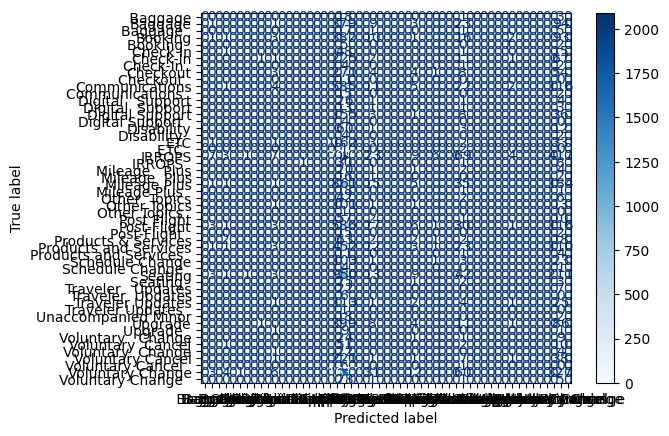

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


#**Factor Analysis for AHT and AST**

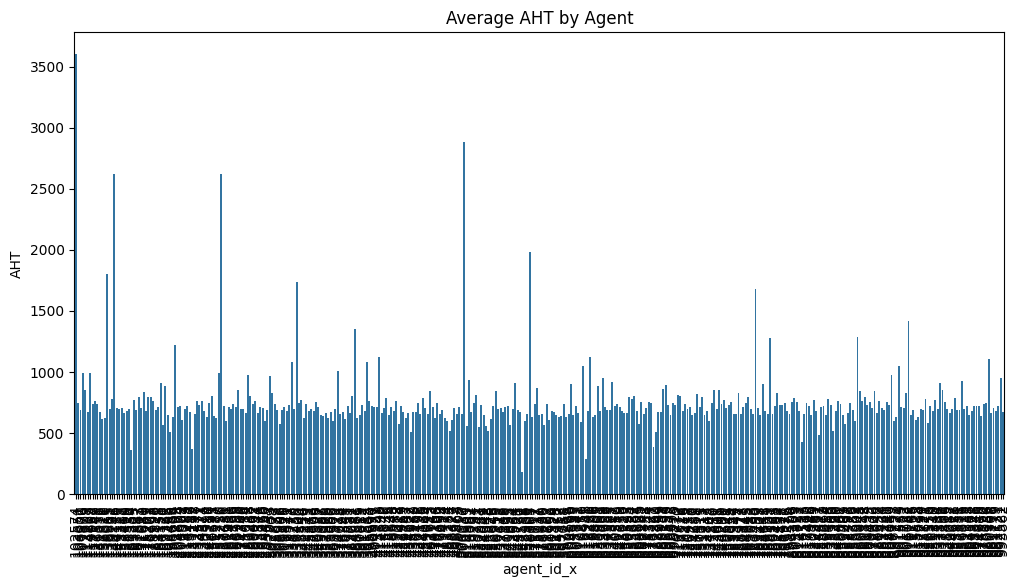

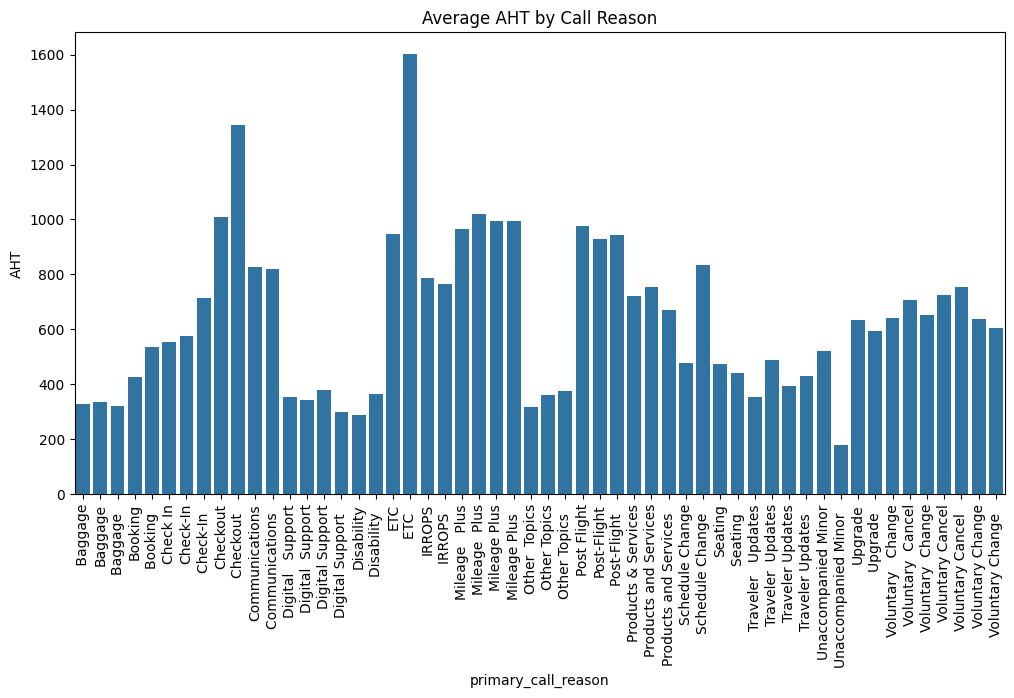

In [25]:
# Analyzing AHT by agent performance
agent_aht = merged_df.groupby('agent_id_x')['AHT'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x='agent_id_x', y='AHT', data=agent_aht)
plt.title("Average AHT by Agent")
plt.xticks(rotation=90)
plt.show()

# Analyzing AHT by call reason
reason_aht = merged_df.groupby('primary_call_reason')['AHT'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x='primary_call_reason', y='AHT', data=reason_aht)
plt.title("Average AHT by Call Reason")
plt.xticks(rotation=90)
plt.show()


#**Quantify the Percentage Difference in AHT for Call Reasons**

1. Calculate the average AHT for each call reason individually.
2. Sort the call reasons by frequency (either most or least frequent).
3. Quantify the percentage difference in AHT between each call reason and the global AHT or another benchmark (e.g., the AHT of the most frequent reason).


In [26]:
# Get the top 10 most frequent call reasons
top_10_most_frequent = merged_df['primary_call_reason'].value_counts().head(10).index

# Get the top 10 least frequent call reasons
top_10_least_frequent = merged_df['primary_call_reason'].value_counts().tail(10).index

# Calculate the average AHT for the top 10 most frequent reasons
most_frequent_aht_avg = merged_df[merged_df['primary_call_reason'].isin(top_10_most_frequent)]['AHT'].mean()

# Calculate the average AHT for the top 10 least frequent reasons
least_frequent_aht_avg = merged_df[merged_df['primary_call_reason'].isin(top_10_least_frequent)]['AHT'].mean()

# Calculate the percentage difference
percentage_diff = ((most_frequent_aht_avg - least_frequent_aht_avg) / least_frequent_aht_avg) * 100

print(f"Percentage Difference between AHT for top 10 most and least frequent reasons: {percentage_diff:.2f}%")


Percentage Difference between AHT for top 10 most and least frequent reasons: 2.40%


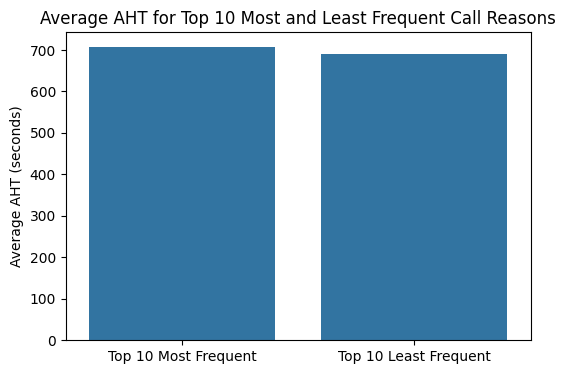

In [27]:
# Bar plot to visualize the AHT for top 10 most and least frequent reasons
plt.figure(figsize=(6,4))
sns.barplot(x=['Top 10 Most Frequent', 'Top 10 Least Frequent'],
            y=[most_frequent_aht_avg, least_frequent_aht_avg])
plt.title("Average AHT for Top 10 Most and Least Frequent Call Reasons")
plt.ylabel('Average AHT (seconds)')
plt.show()


In [28]:
# Calculate the average AHT for each individual call reason
aht_per_reason = merged_df.groupby('primary_call_reason')['AHT'].mean().reset_index()

# Sort call reasons by frequency
frequency_per_reason = merged_df['primary_call_reason'].value_counts().reset_index()
frequency_per_reason.columns = ['primary_call_reason', 'frequency']

# Merge the frequency data with AHT per reason
aht_per_reason = aht_per_reason.merge(frequency_per_reason, on='primary_call_reason')

# Sort by frequency to get the most and least frequent reasons
aht_per_reason_sorted = aht_per_reason.sort_values(by='frequency', ascending=False).reset_index(drop=True)

# Display the AHT for each reason
print(aht_per_reason_sorted)

# Optionally, calculate the percentage difference between the AHT of each reason and the AHT of the most frequent reason
most_frequent_aht = aht_per_reason_sorted['AHT'].iloc[0]  # AHT of the most frequent reason

# Calculate percentage difference for all reasons individually
aht_per_reason_sorted['percentage_diff_from_most_frequent'] = (
    (aht_per_reason_sorted['AHT'] - most_frequent_aht) / most_frequent_aht) * 100

# Display the updated dataframe with percentage difference
print(aht_per_reason_sorted)


        primary_call_reason          AHT  frequency
0                    IRROPS   785.491307      13057
1          Voluntary Change   639.564668      10291
2                   Seating   475.728748       6223
3              Mileage Plus   995.724440       5487
4               Post-Flight   928.410442       3869
5            Communications   826.853665       3779
6     Products and Services   752.815186       2792
7                   Upgrade   633.154362       2682
8                   Baggage   334.449541       2616
9                   Booking   425.701043       2589
10                 Checkout  1008.358696       1840
11                 Check-In   576.281879       1490
12         Voluntary Cancel   724.463190       1304
13          Digital Support   378.313253        996
14                      ETC   947.806452        930
15         Traveler Updates   393.886010        772
16          Schedule Change   478.302687        707
17             Other Topics   362.640845        568
18      Prod

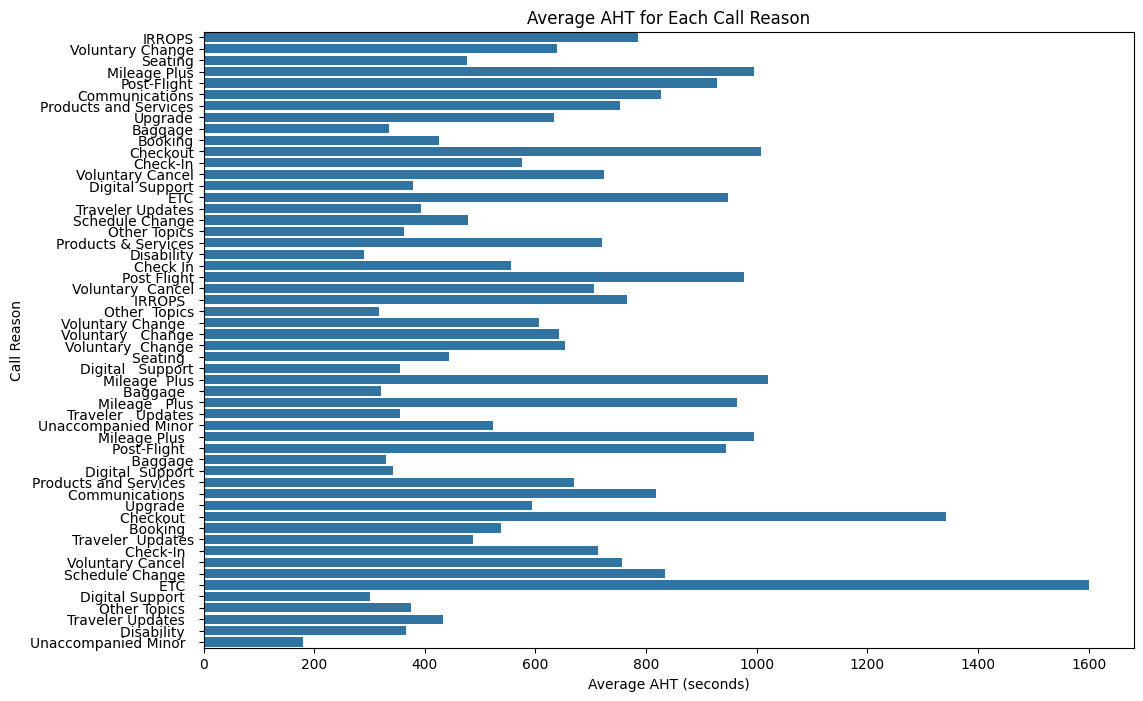

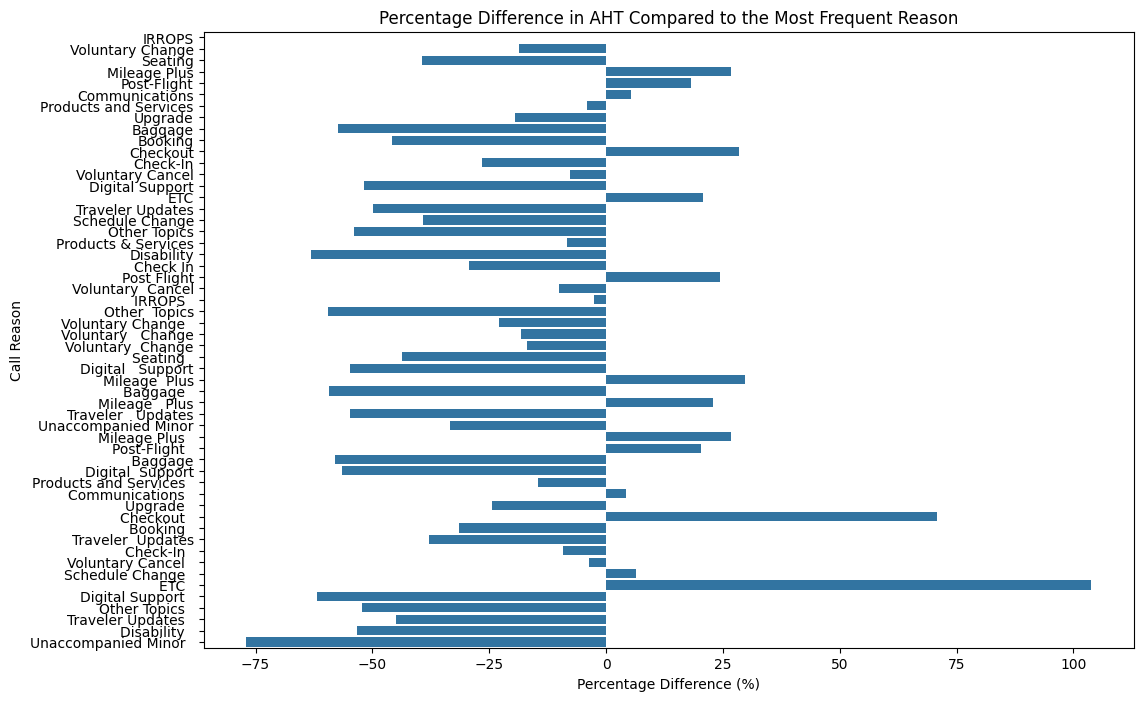

In [29]:
# Bar plot to visualize the AHT for each call reason
plt.figure(figsize=(12,8))
sns.barplot(x='AHT', y='primary_call_reason', data=aht_per_reason_sorted)
plt.title("Average AHT for Each Call Reason")
plt.xlabel('Average AHT (seconds)')
plt.ylabel('Call Reason')
plt.show()

# Bar plot to visualize the percentage difference from the most frequent reason
plt.figure(figsize=(12,8))
sns.barplot(x='percentage_diff_from_most_frequent', y='primary_call_reason', data=aht_per_reason_sorted)
plt.title("Percentage Difference in AHT Compared to the Most Frequent Reason")
plt.xlabel('Percentage Difference (%)')
plt.ylabel('Call Reason')
plt.show()


#**Transcripts and IVR Analysis**
###Word cloud visualization
--To show common phrases in self-solvable issues (e.g., baggage inquiries).



primary_call_reason
IRROPS              13057
Voluntary Change    10291
Seating              6223
Mileage Plus         5487
Post-Flight          3869
Name: count, dtype: int64


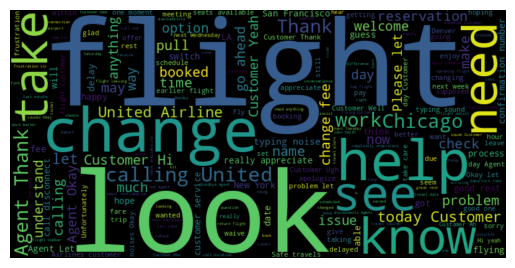

In [30]:
frequent_call_reasons = merged_df['primary_call_reason'].value_counts()
print(frequent_call_reasons.head())

# Word cloud visualization for common reasons
from wordcloud import WordCloud
common_transcripts = merged_df[merged_df['primary_call_reason'].isin(['Booking', 'Baggage'])]  # Adjust based on your frequent call reasons
text = ' '.join(common_transcripts['call_transcript'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
